# The Pima Indians Diabetes Dataset
In this exercise, we use the Naive Bayes algorithm to predict whether or not a patient has diabetes. The dataset is available at:

https://www.kaggle.com/uciml/pima-indians-diabetes-database

The dataset contains information on different features of 768 patients and the diagnosis: 0 (not ill) and 1 (ill). Here we implement from scratch a Naive Bayes classificator and assess its accuracy to predict if a patient has diabetes based on the information provided.

Enjoy!


### We load the libraries we use

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
plt.style.use('classic')

import numpy as np
import pandas as pd

from numpy import *
import random
import math

from IPython.display import display

pi = math.pi

### Exploratory analysis

We first load the dataset file and take a look of the data: the features used to make the prediction, the size of the catalog and check if there is missing data.

In [2]:
full_catalog = pd.read_csv('/home/ealmaraz/dscience/sandbox/datasets/unzip/diabetes.csv')
print (full_catalog.columns)
print("Size of the catalogue: {}".format(len(full_catalog)))
print("Is there any NaN?: {}".format(full_catalog.isnull().any().any()))
full_catalog.head()

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
Size of the catalogue: 768
Is there any NaN?: False


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
positive = full_catalog[full_catalog['Outcome'] == 1]
print('number of patients with diabetes: ',len(positive))

negative = full_catalog[full_catalog['Outcome'] == 0]
print('number of healthy patients: ',len(negative))

number of patients with diabetes:  268
number of healthy patients:  500


Here we show how the measurments are distributed and see if there is some feature we can rely upon to interpret the data.

a) full catalog: blue means healthy, red means ill

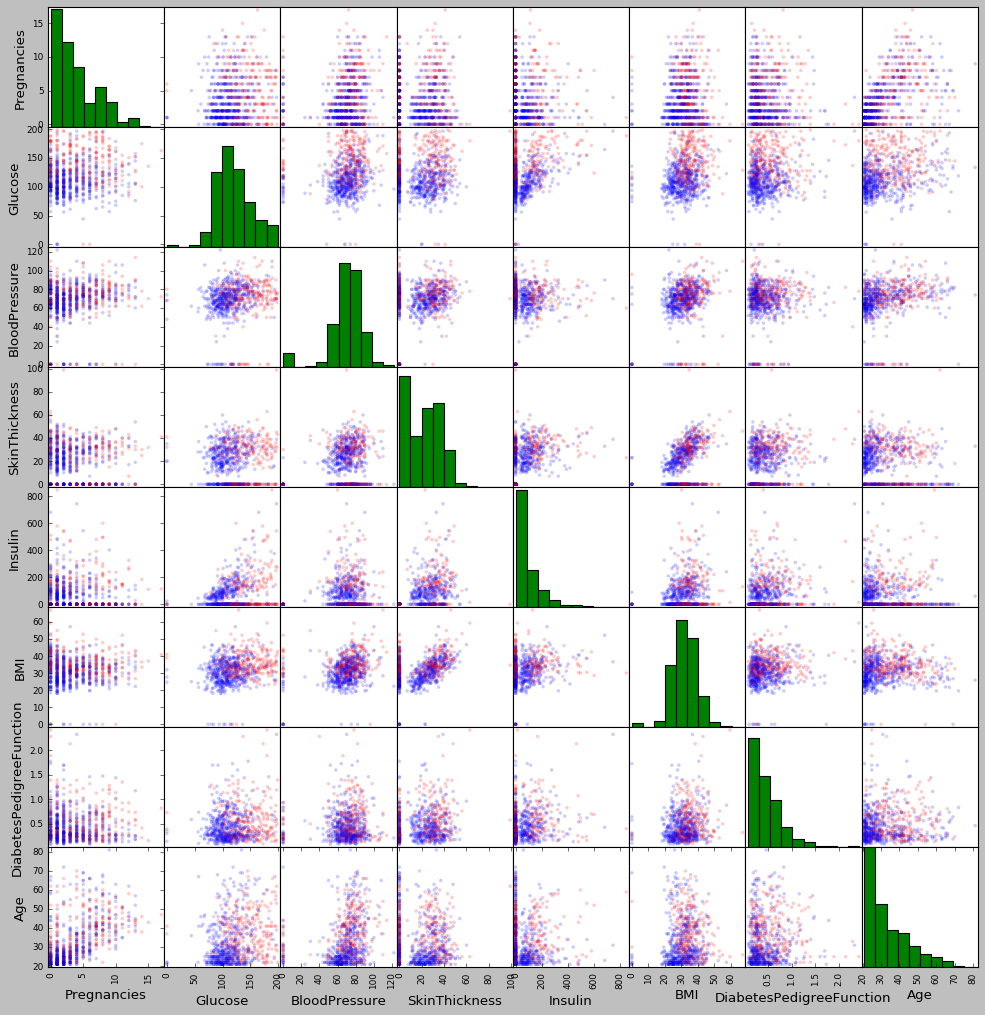

In [4]:
#according to the color map, blue-> 0 (negative) & red-> 1(positive)
df = pd.DataFrame(full_catalog, columns=full_catalog.columns.drop('Outcome'))
pd.plotting.scatter_matrix(df,c=full_catalog['Outcome'].values,figsize=(15, 15),marker='o',
                               hist_kwds={'bins': 10,'color':'green'}, s=10, alpha=.2,cmap=plt.get_cmap('bwr'));

b) Patients with diabetes

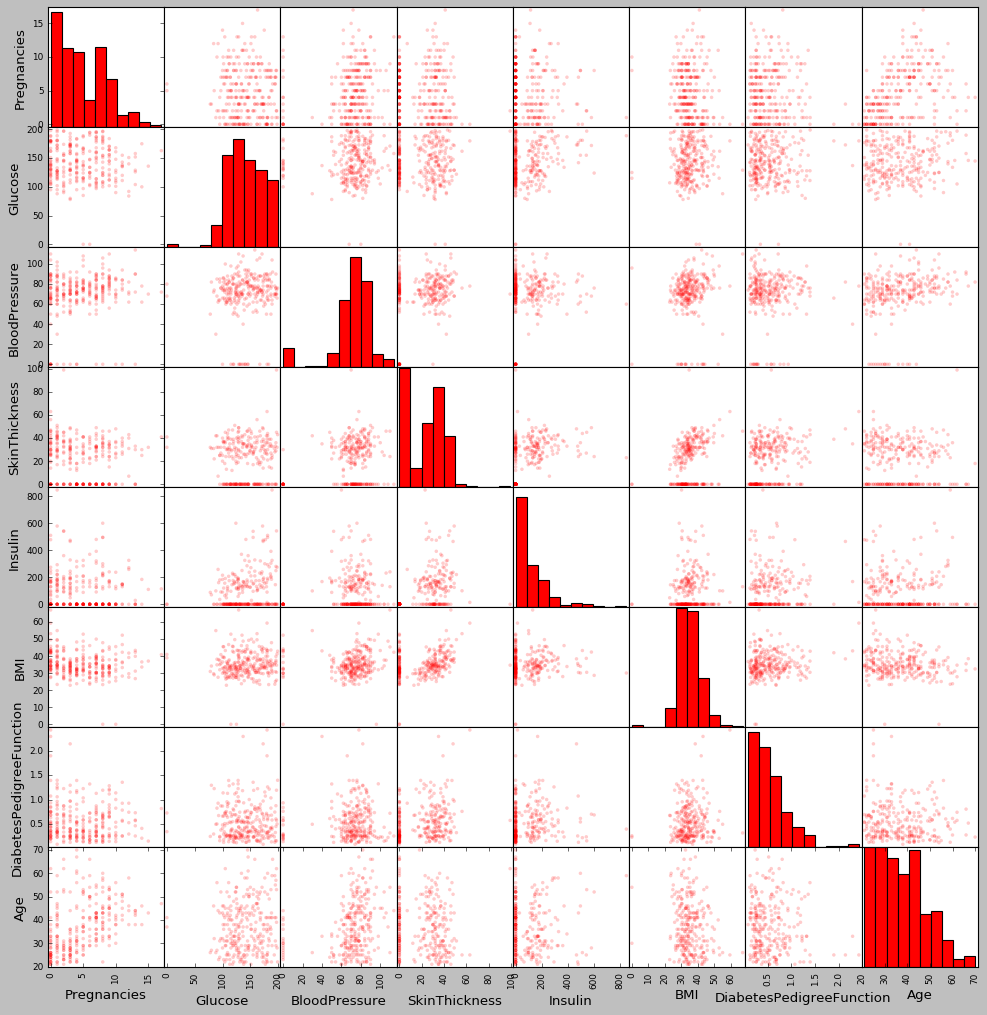

In [5]:
df = pd.DataFrame(positive, columns=positive.columns.drop('Outcome'))
pd.plotting.scatter_matrix(df,c='red',figsize=(15, 15),marker='o',hist_kwds={'bins': 10,'color':'red'}, s=10, alpha=.2);

c) Healthy patients

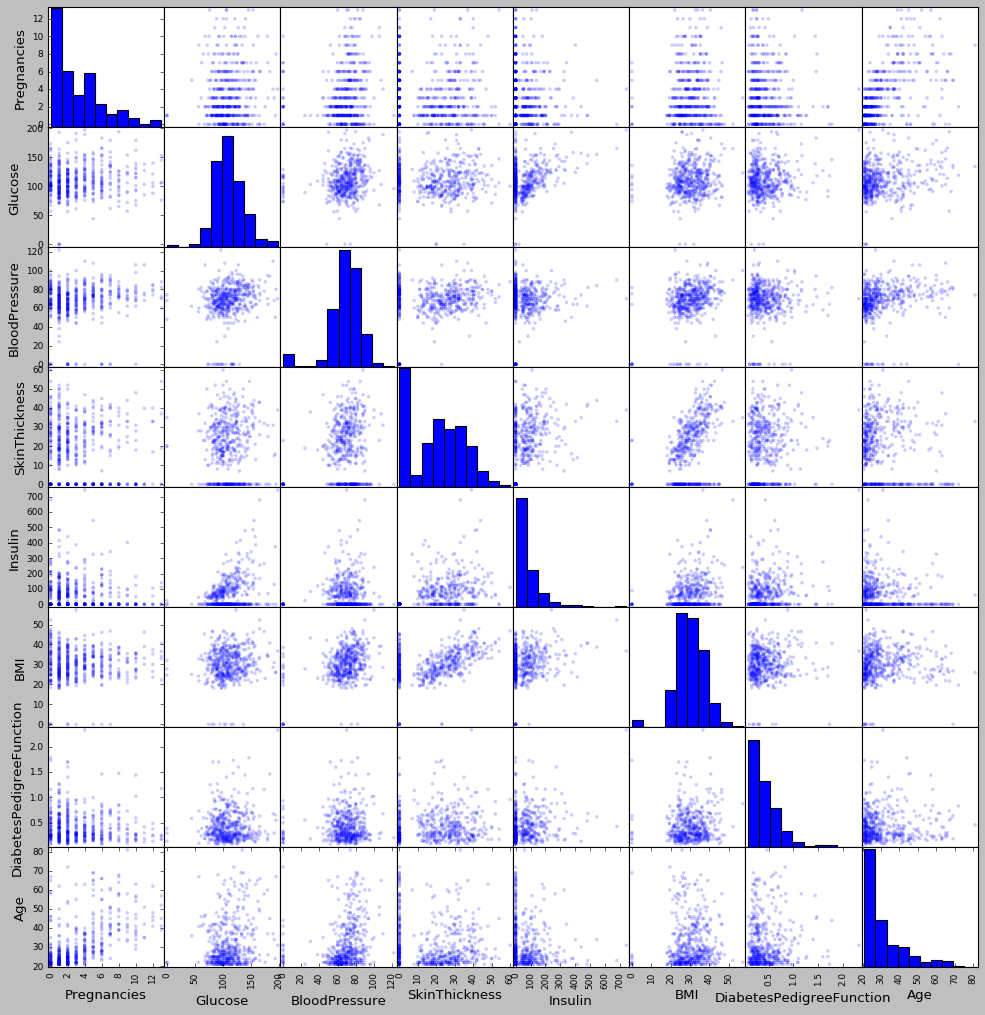

In [6]:
df = pd.DataFrame(negative, columns=negative.columns.drop('Outcome'))
pd.plotting.scatter_matrix(df,c='blue',figsize=(15, 15),marker='o',hist_kwds={'bins': 10,'color':'blue'}, s=10, alpha=.2);

### Naive Bayes classifier functions

This function splits the whole dataset into a training set and a test set. The function takes as arguments:

1. dataset: the dataset to analyze
2. fraction_training: the fraction (between 0 and 1) of the dataset corresponding to the training set
3. msg: debug flag. It this flag is True, the program displays information about what is currently doing

The output is:

1. training_set: a dataframe containing the training set
2. test_set: a dataframe containing the test set


In [7]:
def create_training_test(dataset,fraction_training,msg):
    
    size_dataset=len(dataset); size_training=round(size_dataset*fraction_training); size_test=size_dataset-size_training  
    
    #initially, both the training set and the test sets are made from the whole dataset    
    training_set = dataset.copy(); test_set = dataset.copy()

    #index of the dataset dataframe
    total_idx_list = list(dataset.index.values)
    
    #index of the test set. We use random.sample to pick out non-repeated integers in the dataset.index.values array   
    test_idx_list = random.sample(list(dataset.index.values),size_test)
    test_idx_list.sort()
    
    #index of the training set. This is simply the difference between total_idx_list and test_idx_list
    training_idx_list = list(set(total_idx_list)-set(test_idx_list))

    #once we have the two lists, we drop the corresponding rows from the training and the test dataframes
    training_set.drop(training_set.index[test_idx_list],inplace=True)
    test_set.drop(test_set.index[training_idx_list],inplace=True)
  
    
    if msg == True:
        training_positive = training_set[training_set['Outcome']==1] 
        training_negative = training_set[training_set['Outcome']==0] 
        print("size of the dataset         : {} samples".format(size_dataset))
        print('size of the training set    : {} samples ({} of the whole dataset)'.format(len(training_set),fraction_training))
        print('\tpositive cases in the training set: {}'.format(len(training_positive)))
        print('\tnegative cases in the training set: {}'.format(len(training_negative)))   
        print('size of the test set        : {} samples'.format(len(test_set)))   
        
    return training_set,test_set

This function creates a dictionary storing the mean and the standard deviation for each feature. The function takes as arguments:

1. dataset: the dataset frame to analyze
2. msg: same as before

The otput is:

1. dict_parameters: dictionary containing the mean and the standard deviation for each feature, eg:
    {'Pregnancies':(3.02,0.23),'Age':(25.34,3.2),...}
    
Note that we are splitting the sample into bins

In [8]:
def get_parameters(dataset,msg):
    features = dataset.columns.values;    nbins    = 10;    dict_parameters = {}
    
    #we are excluding 'Outcome' from the loop
    for i in range(0,len(features)-1):
        #we single out the column 'features[i]' from dataset 
        aux_df        = pd.DataFrame(dataset[features[i]])
        #here we make the partition into nbins. aux_df has an extra column indicating 
        #to which bin each instance belongs to
        aux_df['bin'] = pd.cut(aux_df[features[i]],nbins)

        #'counts' is a series whose index is the bin interval and the values are the number
        #of counts in each bin. 
        counts = pd.value_counts(aux_df['bin'])
        
        points_X = np.zeros(nbins)      
        points_Y = np.zeros(nbins)
        
        for j in range(0,nbins):
            points_X[j] = counts.index[j].mid   #the mid point of each bin
            points_Y[j] = counts.iloc[j]        #the number of counts

        total_Y = np.sum(points_Y)
        
        #we compute the mean and the standard deviation. The results are stored in the dictionary 'dict_parameters'
        #whose keys are the labels of the columns and the values are (mu,sigma)
        mu = np.sum(points_X*points_Y)/total_Y  
        sigma2 = np.sum((points_X-mu)**2*points_Y)/(total_Y-1);  sigma = math.sqrt(sigma2)       
        dict_parameters[features[i]]=(mu,sigma)
        
        if msg == True:
            print('\t\tfeature: {}, mean: {}, standard deviation: {}'.format(features[i],mu,sigma))    
        
    return dict_parameters

This function evaluates the probability density function for each feature. The function takes as arguments:

1. instance: a pandas series whose index are the features and whose values are just the measuments for each feature
2. dictionary: dictionary containing the mean and the standard deviation to evaluate the probability density function for each feature in instance

The output is:

1. dict_likelihood: a dictionary with the conditional probability $$P(feature|Outcome=1,0)$$ for each feature

Based on what we get in the exploratory analysis, we use an exponential distribution $$P(x)=\frac{1}{\mu}e^{-x/\mu}$$ for Pregnancies, Insulin, Diabetes Pedigree Function and Age. For Glucose, Blood Pressure, Skin Thickness and BMI we use a gaussian distribution: $$P(x)=\frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{1}{2}\frac{(x-\mu)^2}{\sigma^2}}$$ Strictly speaking, these are the density probability distributions and not the probabilities. To get the probailities we have to multiply $P(x)$ by $dx$. In fact, $P(x)$ might by larger than 1, but when we multiply by $dx$, the result must be always smaller than one. However, this does not matter, since these $dx$ factors are the same both in Outcome=1 and Outcome=0, so they amount to the same multiplicative factor in Baye's theorem and therefore have no influence when deciding if $P(Outcome=1|features)$ is larger than $P(Outcome=0|features)$.

In [9]:
def likelihood(instance,dictionary):
    instance = instance[instance.index != 'Outcome']
    dict_likelihood = {}
    for feature in instance.index:
        mu = dictionary[feature][0]; sigma = dictionary[feature][1]
        measurement = instance[feature]
        if feature in ['Pregnancies','Insulin','DiabetesPedigreeFunction','Age']:
            dict_likelihood[feature] = 1./mu*math.exp(-measurement/mu)
        elif feature in ['Glucose','BloodPressure','SkinThickness','BMI']:
            dict_likelihood[feature] = 1./(math.sqrt(2.*pi)*sigma)*math.exp(-(measurement-mu)**2/(2.*sigma**2))        
    return dict_likelihood

This function implements the Baye's theorem to classify the instance. The input is:

1. lkh_positive: a dictionary with the conditional probailities $P(feature|Outcome=1)$ for each feature
2. lkh_negative: a dictionary with the conditional probailities $P(feature|Outcome=0)$ for each feature
3. prob_positive: the probability to find a ill patient

The output is the classifier prediction: 1 (the patient is ill), 0 (the patient is not ill). Instead of computing $$P(Outcome|features)=\frac{P(features|Outcome)P(Outcome)}{P(features)}$$ we compute the logaritm and since $P(features)$  -the evidence- is the same in both cases, we ignore it to make the prediction. Note that we are assuming all the features to be independent each other

In [10]:
def bayes(lkh_positive,lkh_negative,prob_positive):
    logPositive = 0; logNegative = 0
    
    for feature in lkh_positive:
        logPositive += math.log(lkh_positive[feature]); logNegative += math.log(lkh_negative[feature])
        
    logPositive = logPositive + math.log(prob_positive); logNegative = logNegative + math.log(1.-prob_positive)     
    
    if logPositive > logNegative:
        return 1
    else:
        return 0

### The classifier manager routine 
Here we tie all together

In [11]:
def pima_indians_NBClassifier(training_fraction,msg):
    #we import the catalog
    dataset = pd.read_csv('/home/ealmaraz/dscience/sandbox/datasets/unzip/diabetes.csv')
    
    #here we create the training and the test sets
    training,test=create_training_test(dataset,training_fraction,msg)
    
    #we split the training set into positive (1) and negative (0) values of 'Outcome'
    training_positive = training[training['Outcome']==1]; training_negative = training[training['Outcome']==0]
    prob_positive = len(training_positive)/(len(training))

    
    #we get the parameters for the positive (negative) subsamples in the training set      
    if msg == True:
        print('getting the parameters for the training set...')
        print('\tpositive cases subsample')

    param_positive = get_parameters(training_positive,msg)
    
    if msg == True:
        print('\tnegative cases subsample')
        
    param_negative = get_parameters(training_negative,msg)  
        
    if msg == True:
        print('\tprobability of finding a positive case: {}'.format(prob_positive))   
        print('analizing the test set...')

    #here we compute the accuracy of the classifier by looping over the instances of the test set
    error_count = 0
    
    for idx in test.index.values:
        instance = test.loc[idx]
        likelihood_positive = likelihood(instance,param_positive)
        likelihood_negative = likelihood(instance,param_negative)      

        prediction = bayes(likelihood_positive,likelihood_negative,prob_positive)       
        answer     = int(instance['Outcome'])
        
        if prediction != answer:
            error_count += 1
            if msg == True:
                print('\tclassification error!')  
                
    error_rate = float(error_count)/len(test)
    
    if msg == True:
        print('Results for this implementation:')
        print('\terror rate                        : {}'.format(error_rate))
        print('\tsuccessfull classification rate   : {}'.format(1.-error_rate))

    return error_rate

### Performance of the classifier
a) Single implementation. Here we show the results by running a single implementation of the classifier

In [12]:
training_fraction = 0.75; msg = True
pima_indians_NBClassifier(training_fraction,msg)

size of the dataset         : 768 samples
size of the training set    : 576 samples (0.75 of the whole dataset)
	positive cases in the training set: 208
	negative cases in the training set: 368
size of the test set        : 192 samples
getting the parameters for the training set...
	positive cases subsample
		feature: Pregnancies, mean: 5.081610576923077, standard deviation: 3.7050206000957626
		feature: Glucose, mean: 140.44712019230772, standard deviation: 32.480043451124466
		feature: BloodPressure, mean: 70.64355288461537, standard deviation: 20.672097170045852
		feature: SkinThickness, mean: 23.333692307692306, standard deviation: 15.542095877091166
		feature: Insulin, mean: 119.75780769230768, standard deviation: 119.15602060012547
		feature: BMI, mean: 35.30034855769231, standard deviation: 6.877468281019043
		feature: DiabetesPedigreeFunction, mean: 0.5316923076923078, standard deviation: 0.34047691621010595
		feature: Age, mean: 37.20356971153846, standard deviation: 10.915852

0.21875

b) Multiple implementation. In order to compute the accuracy of the classifier, we need to run it several times and take the mean over all the realizations.

In [13]:
training_fraction = 0.75; nrealizations = 500; msg = False

error_rate    = np.zeros(nrealizations)
success_rate  = np.zeros(nrealizations)

for i in range(0,nrealizations):
    aux = pima_indians_NBClassifier(training_fraction,msg)
    error_rate[i] = aux
    success_rate[i] = 1.-aux

print('Results after {} realizations and training the classifier with {} of the whole sample...'.format(nrealizations,training_fraction))
print('error rate mean: {}, std {}'.format(np.mean(error_rate),np.std(error_rate)))
print('successfull rate mean: {}, std {}'.format(np.mean(success_rate),np.std(success_rate)))

Results after 500 realizations and training the classifier with 0.75 of the whole sample...
error rate mean: 0.2331041666666667, std 0.026629034318765673
successfull rate mean: 0.7668958333333332, std 0.02662903431876567
